## IMPORTS

In [1]:
# Installer les dépendances
!pip install torch>=2.0.0 torchvision>=0.15.0 lightning>=2.0.0 torchmetrics>=0.11.4 \
hydra-core==1.3.2 hydra-colorlog==1.2.0 hydra-optuna-sweeper==1.2.0 \
mlflow opencv-python Pillow ultralytics tifffile \
rootutils pre-commit rich pytest tqdm pandas codecarbon




In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Accéder au fichier
tif_path = '/content/drive/MyDrive/Romane_Martin_urne_sature_10-4.tif'

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import tifffile
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import SAM
from pathlib import Path
import torch
#from codecarbon import EmissionsTracker
from datetime import datetime
import csv

In [4]:
tif_path = '../tests/Romane_Martin_urne_sature_10-4.tif'

## PARAMETRES

In [5]:

GRID_STRIDE   = 64                   # densité des points
POINTS_PER_CALL = 30                # taille des chunks envoyés à SAM
MIN_AREA      = 300                  # aire min d’un masque (en pixels)
CONF_THR      = 0.5                 #  seuil min confiance de SAM
DEDUP_IOU_THR = 0.90                 # seuil de dé-duplication
MIN_MASK_REGION_AREA = 200
IMAGE_3D_PATH = tif_path
SAM_WEIGHTS = "sam_b.pt"   #path sam en local ou bien download from ultralytics
POINT_LABEL = 1


## UTILS

In [6]:
#detection urne par seuillage
def get_urna_mask_threshold(img_gray, thr=60):
    """
    img_gray : [H, W]
    Retourne un masque booléen [H, W]
    """
    if img_gray.ndim != 2:
        raise ValueError(f"get_urna_mask_threshold attend une image 2D grayscale, reçu shape={img_gray.shape}")

    urna_mask = img_gray >= thr
    return urna_mask


In [7]:
# Génération de points en grille
def make_grid_points(h, w, stride, label=1):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    pts = [(int(x), int(y)) for y in ys for x in xs]  # (x, y)
    return pts

In [8]:
# Colorisation des masques pour affichage
def colorize_masks(image, masks_bool, seed=42):
    img = np.asarray(image)
    if img.ndim == 2:
        out = np.dstack([img, img, img]).astype(np.uint8, copy=False)
    elif img.ndim == 3 and img.shape[2] == 3:
        out = img.astype(np.uint8, copy=False).copy()
    else:
        raise ValueError(f"image must be [H,W] or [H,W,3], got {img.shape}")
    H, W = out.shape[:2]
    rng = np.random.default_rng(seed)
    for m in masks_bool:
        m = np.asarray(m, dtype=bool)
        if m.shape != (H, W):
            raise ValueError(f"mask shape {m.shape} != {(H,W)}")
        color = rng.integers(0, 256, size=3, dtype=np.uint8)
        out[m] = color
    return out

## Préparation des données


In [9]:
# exemple extraction slice au milieu
vol = tifffile.imread(IMAGE_3D_PATH)
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")
mid = len(vol) // 2
sl  = vol[mid]

Volume: shape=(1735, 1808, 1595), dtype=uint8


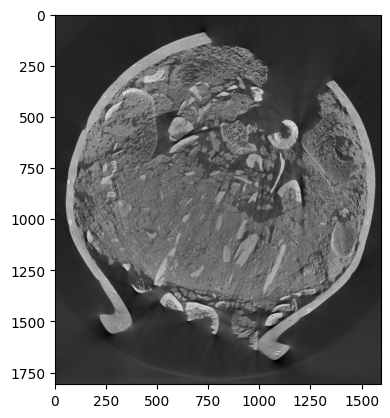

In [9]:
plt.imshow(sl, cmap="gray")
plt.show()

### Pré-traitement et préparation de l'image pour SAM

In [10]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
def apply_clahe(sl, use_clahe=True):
    sl_prep=sl.copy()
    if use_clahe:
        sl_prep = clahe.apply(sl_prep)
    return sl_prep  # [H,W]

def convert_rgb(picture_3D: np.ndarray) -> np.ndarray:
    # convert [H,W] en  [H,W,3]
    return np.repeat(picture_3D[..., np.newaxis], 3, -1)

In [12]:
img_rgb  = convert_rgb(sl)         # [H,W,3]

print("img_rgb:", img_rgb.shape, img_rgb.dtype)

img_rgb: (1808, 1595, 3) uint8


### detection de  l'urne

(np.float64(-0.5), np.float64(1594.5), np.float64(1807.5), np.float64(-0.5))

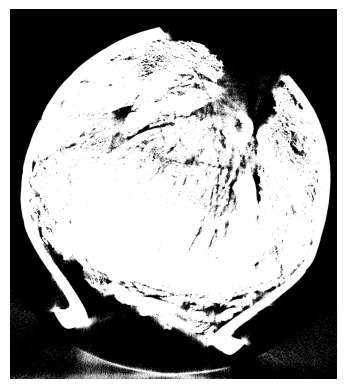

In [13]:
urna_mask = get_urna_mask_threshold(sl, thr=60)
plt.imshow(urna_mask, cmap="gray")
plt.axis("off")

##  SAM Model

In [11]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.device_count())


2.8.0+cu128
12.8
1


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if not Path(SAM_WEIGHTS).exists():
    print(f"Downloading {SAM_WEIGHTS}...")
    model = SAM(SAM_WEIGHTS)
else:
    print(f"{SAM_WEIGHTS} already exists locally")
    model = SAM(SAM_WEIGHTS)

print("SAM chargé")

/home/masalhi002/miniconda3/envs/FUNERIA/lib/python3.9/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Device: cpu
sam_b.pt already exists locally
SAM chargé


### Start emission tracker

In [ ]:
tracker = EmissionsTracker()
tracker.start()


NameError: name 'EmissionsTracker' is not defined

# Inference

In [13]:
import numpy as np
import torch

def sam_inference(
    model,
    img_rgb,                   # image rgb [H,W,3]
    urna_mask,                 # masque booléen [H,W] ou None
    mode="grid",               # grid, auto ou points
    # paramètres prompts
    grid_stride=64, points=None, labels=None,
    # paramètres SAM
    device="cuda", imgsz=640, iou=0.25, max_det=100, conf=0.75,
    # paramètres filtrage
    min_area=300, max_area_ratio=0.05,
    # colorisation des masques
    make_colored=True, color_seed=0):

    if img_rgb.ndim != 3 or img_rgb.shape[2] != 3:
        raise ValueError(f"img rgb  doit être RGB [H,W,3]  {img_rgb.shape}")

    H, W, _ = img_rgb.shape

    # gray image pour la colorisation
    img_gray = img_rgb[..., :3].mean(axis=2).astype(np.uint8)

    img_area = H*W
    max_area = int(max_area_ratio * img_area)

    if urna_mask is not None:
        urna_mask = urna_mask.astype(bool)
        if urna_mask.shape != (H, W):
            raise ValueError(f"urna_mask doit être de taille {(H,W)} reçu {urna_mask.shape}")

    # Préparation des prompts
    filtered_points = None
    filtered_labels = None

    if mode == "grid":
        pts= make_grid_points(H, W, grid_stride)

        if urna_mask is None:
            filtered_points = pts
        else:
            filtered_points = [(x, y) for (x, y) in pts if urna_mask[y, x]]

        filtered_labels = [1] * len(filtered_points)

        if len(filtered_points) == 0:
            colored = np.dstack([img_gray]*3).astype(np.uint8)
            return [], colored, {"mode": "grid", "n_masks_raw": 0,
                                 "n_masks_filtered": 0, "n_points": 0}

    elif mode == "points":
        if points is None:
            raise ValueError("mode='points' mais aucun points fourni")
        filtered_points = points
        filtered_labels = labels if labels is not None else [1]*len(points)

    elif mode == "auto":
        filtered_points = None
        filtered_labels = None

    else:
        raise ValueError("mode doit être 'grid', 'auto' ou 'points'")

    with torch.inference_mode():
        if filtered_points is not None:
            results = model(
                img_rgb,
                points=filtered_points,
                labels=filtered_labels,
                device=device,
                imgsz=imgsz,
                iou=iou,
                max_det=max_det,
                conf=conf,
                agnostic_nms=True,
                show=False,
            )
        else:
            results = model(
                img_rgb,
                device=device,
                imgsz=imgsz,
                iou=iou,
                max_det=max_det,
                conf=conf,
                agnostic_nms=True,
                show=False,
            )

    res = results[0]

    if res.masks is None:
        colored = np.dstack([img_gray] * 3).astype(np.uint8)
        return [], colored, {"mode": mode, "n_masks_raw": 0,"n_masks_filtered": 0, "n_points": 0}

    masks = res.masks.data.cpu().numpy().astype(np.uint8)
    masks = np.squeeze(masks)

    if masks.ndim == 2:
        masks = masks[None, ...]

    print(f"[{mode}] masks brutes detectés", masks.shape)

    if urna_mask is None:
        print("[INFO] Pas de masque d’urne fourni : aucun filtrage appliqué.")
        filtered_masks = (masks > 0)

        # Colorisation
        colored = colorize_masks(img_gray, filtered_masks, seed=color_seed) if make_colored else None

        return list(filtered_masks), colored, {
            "mode": mode,
            "n_masks_raw": int(masks.shape[0]),
            "n_masks_filtered": int(filtered_masks.shape[0]),
            "n_points": 0 if filtered_points is None else len(filtered_points),
            "min_area": min_area,
            "max_area": max_area,
        }


    # Restreindre les masques à l’intérieur de l’urne
    masks = np.array([(m > 0) & urna_mask for m in masks], dtype=bool)

    # Filtrage par aire
    areas = np.array([m.sum() for m in masks])
    keep_idx = np.where((areas >= min_area) & (areas <= max_area))[0]
    filtered_masks = masks[keep_idx]

    print(f"[{mode}] masks filtrés", filtered_masks.shape)

    # Colorisation
    if make_colored:
        if filtered_masks.size == 0:
            colored = np.dstack([img_gray] * 3).astype(np.uint8)
        else:
            colored = colorize_masks(img_gray, filtered_masks, seed=color_seed)
    else:
        colored = None

    # Informations pour debug
    info = {
        "mode": mode,
        "n_masks_raw": int(masks.shape[0]),
        "n_masks_filtered": int(filtered_masks.shape[0]),
        "n_points": 0 if filtered_points is None else len(filtered_points),
        "min_area": min_area,
        "max_area": max_area,
    }

    return list(filtered_masks), colored, info



0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 10900.1ms
Speed: 103.0ms preprocess, 10900.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)
[auto] masks brutes detectés (23, 1808, 1595)
[auto] masks filtrés (22, 1808, 1595)
{'mode': 'auto', 'n_masks_raw': 23, 'n_masks_filtered': 22, 'n_points': 0, 'min_area': 300, 'max_area': 144188}


(np.float64(-0.5), np.float64(1594.5), np.float64(1807.5), np.float64(-0.5))

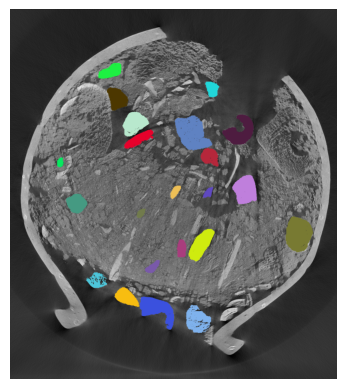

In [ ]:
masks_auto, colored_auto, info_auto = sam_inference(
    model,
    urna_mask=urna_mask,
    img_rgb=img_rgb,
    mode="auto",
    device=device,
    imgsz=640,
    iou=0.25,
    max_det=100,
    conf=0.75,
    min_area=300,
    max_area_ratio=0.05,
)
print(info_auto)
plt.imshow(colored_auto)
plt.axis("off")


In [14]:
import torch
print("CUDA dispo :", torch.cuda.is_available())
print("Nb GPU :", torch.cuda.device_count())
print("Nom :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA dispo : False
Nb GPU : 1
Nom : None



0: 640x640 1 2, 1 5, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 15, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 25, 1 33, 1 34, 1 35, 1 38, 1 41, 1 44, 1 45, 1 46, 1 49, 1 50, 1 58, 1 59, 1 63, 1 64, 1 65, 1 67, 1 72, 1 75, 1 78, 1 79, 1 82, 1 83, 1 87, 1 89, 1 90, 1 92, 1 93, 1 94, 1 96, 1 97, 1 98, 1 100, 1 101, 1 105, 1 110, 1 111, 1 113, 1 114, 1 115, 1 117, 1 118, 1 119, 1 120, 1 126, 1 128, 1 131, 1 133, 1 139, 1 141, 1 144, 1 145, 1 153, 1 154, 1 155, 1 158, 1 164, 1 166, 1 170, 1 171, 1 174, 1 176, 1 178, 1 179, 1 180, 1 181, 1 189, 1 190, 1 193, 1 194, 1 199, 1 200, 1 201, 1 202, 1 203, 1 204, 1 205, 1 206, 1 207, 1 208, 1 209, 1 210, 1 212, 1 214, 1 215, 1 219, 1 223, 1 224, 1 225, 1 226, 1 227, 1 228, 1 229, 1 231, 1 232, 1 238, 1 239, 1 241, 1 242, 1 243, 1 246, 1 247, 1 248, 1 249, 1 250, 1 252, 1 253, 1 254, 1 256, 1 257, 1 263, 1 264, 1 269, 1 270, 1 272, 1 273, 1 274, 1 276, 1 277, 1 278, 1 279, 1 282, 1 283, 1 284, 1 287, 1 290, 1 293, 1 294, 1 296, 1 297, 1 299, 1 301, 1 302

(np.float64(-0.5), np.float64(1594.5), np.float64(1807.5), np.float64(-0.5))

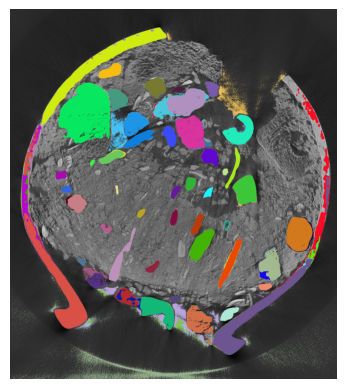

In [ ]:
masks_grid, colored_grid, info_grid = sam_inference(
    model,
    img_rgb=img_rgb,
    urna_mask=urna_mask,
    mode="grid",
    device=device,
    grid_stride=60,
    imgsz=640,
    iou=0.25,
    max_det=100,
    conf=0.75,
    min_area=0,
    max_area_ratio=0.02
)
print(info_grid)
plt.imshow(colored_grid)
plt.axis("off")


## Segmentation avec bounding box


In [16]:
def make_grid_boxes(h, w, stride, box_size=64):
    """Génère une grille de bounding boxes"""
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    boxes = []
    for y in ys:
        for x in xs:
            x1 = max(0, x - box_size // 2)
            y1 = max(0, y - box_size // 2)
            x2 = min(w, x + box_size // 2)
            y2 = min(h, y + box_size // 2)
            boxes.append([x1, y1, x2, y2])
    return boxes


def sam_inference_boxes(
    model,
    img_rgb,                   # image rgb [H,W,3]
    urna_mask,                 # masque booléen [H,W] ou None
    boxes,                     # liste de boxes [[x1,y1,x2,y2], ...]
    # paramètres SAM
    device="cuda", imgsz=640, iou=0.25, max_det=100, conf=0.75,
    # paramètres filtrage
    min_area=300, max_area_ratio=0.05,
    # colorisation des masques
    make_colored=True, color_seed=0):
    """
    Inférence SAM avec prompts de type bounding boxes
    """

    if img_rgb.ndim != 3 or img_rgb.shape[2] != 3:
        raise ValueError(f"img rgb doit être RGB [H,W,3] reçu {img_rgb.shape}")

    H, W, _ = img_rgb.shape

    # Gray image pour la colorisation
    img_gray = img_rgb[..., :3].mean(axis=2).astype(np.uint8)

    img_area = H * W
    max_area = int(max_area_ratio * img_area)

    if urna_mask is not None:
        urna_mask = urna_mask.astype(bool)
        if urna_mask.shape != (H, W):
            raise ValueError(f"urna_mask doit être de taille {(H,W)} reçu {urna_mask.shape}")

    # Filtrer les boxes qui sont dans l'urne si urna_mask fourni
    if urna_mask is not None:
        filtered_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            # Vérifier si le centre de la box est dans l'urne
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            if urna_mask[cy, cx]:
                filtered_boxes.append(box)
    else:
        filtered_boxes = boxes

    if len(filtered_boxes) == 0:
        colored = np.dstack([img_gray] * 3).astype(np.uint8)
        return [], colored, {"mode": "boxes", "n_masks_raw": 0,
                             "n_masks_filtered": 0, "n_boxes": 0}

    with torch.inference_mode():
        results = model(
            img_rgb,
            bboxes=filtered_boxes,
            device=device,
            imgsz=imgsz,
            iou=iou,
            max_det=max_det,
            conf=conf,
            agnostic_nms=True,
            show=False,
        )

    res = results[0]

    if res.masks is None:
        colored = np.dstack([img_gray] * 3).astype(np.uint8)
        return [], colored, {"mode": "boxes", "n_masks_raw": 0, "n_masks_filtered": 0, "n_boxes": len(filtered_boxes)}

    masks = res.masks.data.cpu().numpy().astype(np.uint8)
    masks = np.squeeze(masks)

    if masks.ndim == 2:
        masks = masks[None, ...]

    print(f"[boxes] masks brutes détectés", masks.shape)

    if urna_mask is None:
        print("[INFO] Pas de masque d'urne fourni : aucun filtrage appliqué.")
        filtered_masks = (masks > 0)

        # Colorisation
        colored = colorize_masks(img_gray, filtered_masks, seed=color_seed) if make_colored else None

        return list(filtered_masks), colored, {
            "mode": "boxes",
            "n_masks_raw": int(masks.shape[0]),
            "n_masks_filtered": int(filtered_masks.shape[0]),
            "n_boxes": len(filtered_boxes),
            "min_area": min_area,
            "max_area": max_area,
        }

    # Restreindre les masques à l'intérieur de l'urne
    masks = np.array([(m > 0) & urna_mask for m in masks], dtype=bool)

    # Filtrage par aire
    areas = np.array([m.sum() for m in masks])
    keep_idx = np.where((areas >= min_area) & (areas <= max_area))[0]
    filtered_masks = masks[keep_idx]

    print(f"[boxes] masks filtrés", filtered_masks.shape)

    # Colorisation
    if make_colored:
        if filtered_masks.size == 0:
            colored = np.dstack([img_gray] * 3).astype(np.uint8)
        else:
            colored = colorize_masks(img_gray, filtered_masks, seed=color_seed)
    else:
        colored = None

    # Informations pour debug
    info = {
        "mode": "boxes",
        "n_masks_raw": int(masks.shape[0]),
        "n_masks_filtered": int(filtered_masks.shape[0]),
        "n_boxes": len(filtered_boxes),
        "min_area": min_area,
        "max_area": max_area,
    }

    return list(filtered_masks), colored, info

In [ ]:
# Extraire une slice au milieu du volume
sl = vol[mid]
sl = apply_clahe(sl, use_clahe=True)
img_rgb = convert_rgb(sl)
urna_mask = get_urna_mask_threshold(sl, thr=60)

print(f"Image préparée: {img_rgb.shape}")
print(f"Masque urne: {urna_mask.shape}, pixels dans urne: {urna_mask.sum()}")

Image préparée: (1808, 1595, 3)
Masque urne: (1808, 1595), pixels dans urne: 2070136


Nombre de boxes générées: 700

0: 640x640 1 0, 1 3, 1 4, 1 6, 1 7, 1 11, 1 13, 1 15, 1 16, 1 17, 1 19, 1 20, 1 28, 1 29, 1 30, 1 31, 1 42, 1 49, 1 51, 1 52, 1 56, 1 57, 1 58, 1 59, 1 63, 1 65, 1 69, 1 70, 1 71, 1 72, 1 73, 1 75, 1 76, 1 78, 1 81, 1 82, 1 86, 1 89, 1 91, 1 94, 1 95, 1 97, 1 104, 1 105, 1 108, 1 109, 1 110, 1 111, 1 112, 1 115, 1 116, 1 124, 1 126, 1 128, 1 132, 1 134, 1 136, 1 137, 1 140, 1 144, 1 145, 1 146, 1 147, 1 148, 1 149, 1 151, 1 156, 1 162, 1 163, 1 165, 1 168, 1 173, 1 174, 1 175, 1 177, 1 178, 1 180, 1 184, 1 185, 1 186, 1 187, 1 189, 1 190, 1 194, 1 195, 1 197, 1 199, 1 201, 1 205, 1 209, 1 217, 1 219, 1 222, 1 223, 1 224, 1 226, 1 229, 1 237, 1 239, 1 241, 1 246, 1 254, 1 256, 1 258, 1 262, 1 263, 1 266, 1 267, 1 269, 1 270, 1 271, 1 276, 1 279, 1 281, 1 283, 1 284, 1 285, 1 286, 1 287, 1 289, 1 291, 1 295, 1 296, 1 301, 1 304, 1 306, 1 312, 1 313, 1 315, 1 316, 1 321, 1 323, 1 326, 1 331, 1 337, 1 338, 1 343, 1 345, 1 350, 1 352, 1 356, 1 358, 1 363, 1 36

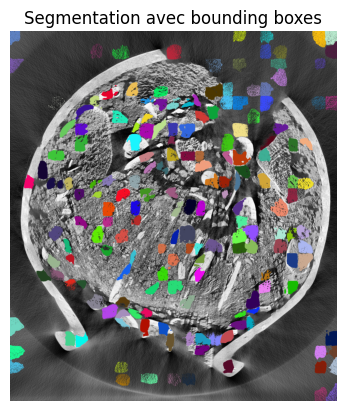

In [ ]:
# Obtenir les dimensions de l'image
H, W = img_rgb.shape[:2]

# Générer les bounding boxes
boxes = make_grid_boxes(H, W, GRID_STRIDE, 64)
print(f"Nombre de boxes générées: {len(boxes)}")

# Lancer l'inférence avec bounding boxes
masks_boxes, colored_boxes, info_boxes = sam_inference_boxes(
    model,
    img_rgb=img_rgb,
    urna_mask=urna_mask,
    boxes=boxes,
    device=device,
    imgsz=640,
    iou=0.25,
    max_det=100,
    conf=0.75,
    min_area=300,
    max_area_ratio=0.05
)

print(info_boxes)
plt.imshow(colored_boxes)
plt.axis("off")
plt.title("Segmentation avec bounding boxes")
plt.show()



## Analyse de l'IOU entre Slices


In [23]:
def match_masks_between_slices(masks_prev, masks_curr, iou_threshold=0.3):
    """
    Calcule l'IoU entre deux ensembles de masques (combinés)
    """
    if len(masks_prev) == 0 or len(masks_curr) == 0:
        return 0.0

    # Combiner les masques dans un seul mask binaire
    mask_prev_combined = np.zeros_like(masks_prev[0], dtype=bool)
    for mask in masks_prev:
        mask_prev_combined |= mask

    # Combiner les masques dans un seul mask binaire
    mask_curr_combined = np.zeros_like(masks_curr[0], dtype=bool)
    for mask in masks_curr:
        mask_curr_combined |= mask

    # Calculer l'IoU entre les deux masks combinées
    intersection = np.logical_and(mask_prev_combined, mask_curr_combined)
    union = np.logical_or(mask_prev_combined, mask_curr_combined)

    if np.sum(union) == 0:
        return 0.0

    iou = np.sum(intersection) / np.sum(union)

    return iou


In [ ]:
# generating multi slice segmentation
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")


Volume: shape=(1735, 1808, 1595), dtype=uint8


In [ ]:
# Calculer l'IoU pour 10 slices au milieu
slice_beginning = mid - 5
slice_end = mid + 5
iou_values_grid = []

print("=== Analyse IoU avec grille de points ===\n")

for i in range(slice_beginning, slice_end):
    print(f"Slice {i - slice_beginning + 1}/{slice_end - slice_beginning}")

    # Slice i
    sl_prev = vol[i]
    sl_prev = apply_clahe(sl_prev, use_clahe=True)
    img_rgb_prev = convert_rgb(sl_prev)
    urna_mask_prev = get_urna_mask_threshold(sl_prev, thr=60)

    # Slice i+1
    sl_curr = vol[i + 1]
    sl_curr = apply_clahe(sl_curr, use_clahe=True)
    img_rgb_curr = convert_rgb(sl_curr)
    urna_mask_curr = get_urna_mask_threshold(sl_curr, thr=60)

    # Inférence sur les deux slices
    masks_prev, _, _ = sam_inference(
        model,
        img_rgb=img_rgb_prev,
        urna_mask=urna_mask_prev,
        mode="grid",
        grid_stride=GRID_STRIDE,
        device=device,
        imgsz=512,
        conf=CONF_THR,
        min_area=MIN_AREA,
        max_area_ratio=0.05,
        make_colored=False
    )

    masks_curr, _, _ = sam_inference(
        model,
        img_rgb=img_rgb_curr,
        urna_mask=urna_mask_curr,
        mode="grid",
        grid_stride=GRID_STRIDE,
        device=device,
        imgsz=512,
        conf=CONF_THR,
        min_area=MIN_AREA,
        max_area_ratio=0.05,
        make_colored=False
    )

    # Calculer l'IoU
    iou = match_masks_between_slices(masks_prev, masks_curr)
    iou_values_grid.append(iou)
    print(f"  IoU: {iou:.4f}")

    # Libérer la mémoire GPU
    if device == "cuda":
        torch.cuda.empty_cache()
        del masks_prev, masks_curr, img_rgb_prev, img_rgb_curr
        torch.cuda.empty_cache()

print("\n=== Résultats grille de points ===")
print(f"IoU values: {iou_values_grid}")
print(f"Moyenne IoU: {np.mean(iou_values_grid):.4f}")

=== Analyse IoU avec grille de points ===

Slice 1/10

0: 512x512 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 78, 1 80, 1 81, 1 82, 1 83, 1 85, 1 86, 1 87, 1 88, 1 90, 1 91, 1 93, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 138, 1 139, 1 140, 1 141, 1 142, 1 143, 1 144, 1 145, 1 146, 1 148, 1 149, 1 151, 1 152, 1 153, 1 154, 1 155, 1 156, 1 157, 1 158, 1 159, 1 160, 1 16

In [ ]:
iou_values_boxes = []
slice_beginning = mid - 5
slice_end = mid + 5
print("\n=== Analyse IoU avec bounding boxes ===\n")

# Générer les boxes une fois
H_vol, W_vol = vol[0].shape
boxes = make_grid_boxes(H_vol, W_vol, GRID_STRIDE, 64)

for i in range(slice_beginning, slice_end):
    print(f"Slice {i - slice_beginning + 1}/{slice_end - slice_beginning}")

    # Slice i
    sl_prev = vol[i]
    sl_prev = apply_clahe(sl_prev, use_clahe=True)
    img_rgb_prev = convert_rgb(sl_prev)
    urna_mask_prev = get_urna_mask_threshold(sl_prev, thr=60)

    # Slice i+1
    sl_curr = vol[i + 1]
    sl_curr = apply_clahe(sl_curr, use_clahe=True)
    img_rgb_curr = convert_rgb(sl_curr)
    urna_mask_curr = get_urna_mask_threshold(sl_curr, thr=60)

    # Inférence sur les deux slices
    masks_prev, _, _ = sam_inference_boxes(
        model,
        img_rgb=img_rgb_prev,
        urna_mask=urna_mask_prev,
        boxes=boxes,
        device=device,
        imgsz=640,
        conf=CONF_THR,
        min_area=MIN_AREA,
        max_area_ratio=0.05,
        make_colored=False
    )

    masks_curr, _, _ = sam_inference_boxes(
        model,
        img_rgb=img_rgb_curr,
        urna_mask=urna_mask_curr,
        boxes=boxes,
        device=device,
        imgsz=640,
        conf=CONF_THR,
        min_area=MIN_AREA,
        max_area_ratio=0.05,
        make_colored=False
    )

    # Calculer l'IoU
    iou = match_masks_between_slices(masks_prev, masks_curr)
    iou_values_boxes.append(iou)
    print(f"  IoU: {iou:.4f}")

    # Libérer la mémoire GPU
    if device == "cuda":
        torch.cuda.empty_cache()
        del masks_prev, masks_curr, img_rgb_prev, img_rgb_curr
        torch.cuda.empty_cache()

print("\n=== Résultats bounding boxes ===")
print(f"IoU values: {iou_values_boxes}")
print(f"Moyenne IoU: {np.mean(iou_values_boxes):.4f}")


=== Analyse IoU avec bounding boxes ===

Slice 1/10

0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 139, 1 140, 1 141, 1 142, 1 143, 1 144, 1 145, 1 146, 1 147, 1 148, 1 149, 1 

In [ ]:
ean_iou_grid = np.mean(iou_values_grid)
mean_iou_boxes = np.mean(iou_values_boxes)

print("\n" + "="*60)
print("COMPARAISON FINALE")
print("="*60)
print(f"Moyenne IoU (grille de points): {mean_iou_grid:.4f}")
print(f"Moyenne IoU (bounding boxes):   {mean_iou_boxes:.4f}")
print(f"Différence: {abs(mean_iou_grid - mean_iou_boxes):.4f}")
print("="*60)

# Visualisation
plt.figure(figsize=(10, 6))
x_axis = range(1, len(iou_values_grid) + 1)
plt.plot(x_axis, iou_values_grid, marker='o', label=f"Grille de points (moy={mean_iou_grid:.4f})", linewidth=2)
plt.plot(x_axis, iou_values_boxes, marker='s', label=f"Bounding boxes (moy={mean_iou_boxes:.4f})", linewidth=2)
plt.xlabel("Index de paire de slices", fontsize=12)
plt.ylabel("IoU", fontsize=12)
plt.title("Comparaison IoU entre slices consécutives\n(Grille de points vs Bounding boxes)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def sam_inference_with_yolo(
    model,
    model_yolo,
    img_rgb,                   # image rgb [H,W,3]
    use_yolo=True,             # utiliser YOLO pour la ROI
    use_threshold=True,        # utiliser le seuillage pour l'urne
    threshold_value=60,        # seuil pour get_urna_mask_threshold
    yolo_conf=0.25,            # confiance YOLO
    mode="grid",               # grid, auto ou points
    # paramètres prompts
    grid_stride=64, points=None, labels=None,
    # paramètres SAM
    device="cuda", imgsz=640, iou=0.25, max_det=100, conf=0.75,
    # paramètres filtrage
    min_area=300, max_area_ratio=0.05,
    # colorisation des masques
    make_colored=True, color_seed=0):
    """
    Inférence SAM avec combinaison optionnelle YOLO + seuillage
    """

    if img_rgb.ndim != 3 or img_rgb.shape[2] != 3:
        raise ValueError(f"img rgb doit être RGB [H,W,3] reçu {img_rgb.shape}")

    H, W, _ = img_rgb.shape
    img_gray = img_rgb[..., :3].mean(axis=2).astype(np.uint8)

    # Créer les masques
    yolo_mask = None
    threshold_mask = None
    bbox_yolo = None

    if use_yolo:
        bbox_yolo, yolo_mask = detect_urn_with_yolo(model_yolo, img_gray, conf=yolo_conf)

    if use_threshold:
        threshold_mask = get_urna_mask_threshold(img_gray, thr=threshold_value)

    # Combiner les masques
    if use_yolo and use_threshold:
        urna_mask = combine_yolo_and_threshold_masks(yolo_mask, threshold_mask)
    elif use_yolo:
        urna_mask = yolo_mask
    elif use_threshold:
        urna_mask = threshold_mask
    else:
        urna_mask = None

    # Utiliser sam_inference existant
    masks, colored, info = sam_inference(
        model,
        img_rgb=img_rgb,
        urna_mask=urna_mask,
        mode=mode,
        grid_stride=grid_stride,
        points=points,
        labels=labels,
        device=device,
        imgsz=imgsz,
        iou=iou,
        max_det=max_det,
        conf=conf,
        min_area=min_area,
        max_area_ratio=max_area_ratio,
        make_colored=make_colored,
        color_seed=color_seed
    )

    # Ajouter les infos YOLO
    info['bbox_yolo'] = bbox_yolo
    info['use_yolo'] = use_yolo
    info['use_threshold'] = use_threshold

    return masks, colored, info, bbox_yolo



## Usage Yolo pour la détection des urnes

In [ ]:
from ultralytics import YOLO

# Charger le modèle YOLO
model_yolo = YOLO("yolo11n.pt")


def normalize_to_uint8(img):
    """Normalise une image en uint8"""
    if img.dtype == np.uint8:
        return img
    mn, mx = float(img.min()), float(img.max())
    if mx > mn:
        return ((img - mn) / (mx - mn) * 255).astype(np.uint8)
    return np.zeros_like(img, dtype=np.uint8)


def detect_urn_with_yolo(model_yolo, image, conf=0.25):
    """
    Détecte l'urne avec YOLO et retourne une bbox et un masque ROI

    Returns:
        bbox: [x1, y1, x2, y2] ou None
        mask_roi: masque booléen [H, W]
    """
    # Normaliser l'image
    img = normalize_to_uint8(image)
    if img.ndim == 2:
        img = np.dstack([img, img, img])

    # Détection YOLO
    results = model_yolo.predict(source=img, conf=conf, verbose=False)

    if len(results) == 0 or len(results[0].boxes) == 0:
        print("[YOLO] Aucun objet détecté, utilisation de l'image complète")
        return None, np.ones(image.shape[:2], dtype=bool)

    # Prendre la plus grande bbox (supposée être l'urne)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    largest_idx = np.argmax(areas)
    bbox = boxes[largest_idx].astype(int)

    # Créer un masque ROI
    mask_roi = np.zeros(image.shape[:2], dtype=bool)
    x1, y1, x2, y2 = bbox
    mask_roi[y1:y2, x1:x2] = True

    print(f"[YOLO] Urne détectée à [{x1}, {y1}, {x2}, {y2}]")
    return bbox, mask_roi


def combine_yolo_and_threshold_masks(yolo_mask, threshold_mask):
    """
    Combine le masque YOLO (ROI large) avec le masque de seuillage (urne précise)

    Returns:
        combined_mask: intersection des deux masques
    """
    if yolo_mask is None:
        return threshold_mask
    if threshold_mask is None:
        return yolo_mask

    # Intersection des deux masques
    combined = np.logical_and(yolo_mask, threshold_mask)

    print(f"[Combinaison] YOLO: {yolo_mask.sum()} pixels, Seuillage: {threshold_mask.sum()} pixels, Combiné: {combined.sum()} pixels")

    return combined

In [ ]:
def sam_inference_with_yolo(
    model,
    model_yolo,
    img_rgb,                   # image rgb [H,W,3]
    use_yolo=True,             # utiliser YOLO pour la ROI
    use_threshold=True,        # utiliser le seuillage pour l'urne
    threshold_value=60,        # seuil pour get_urna_mask_threshold
    yolo_conf=0.25,            # confiance YOLO
    mode="grid",               # grid, auto ou points
    # paramètres prompts
    grid_stride=64, points=None, labels=None,
    # paramètres SAM
    device="cuda", imgsz=640, iou=0.25, max_det=100, conf=0.75,
    # paramètres filtrage
    min_area=300, max_area_ratio=0.05,
    # colorisation des masques
    make_colored=True, color_seed=0):
    """
    Inférence SAM avec combinaison optionnelle YOLO + seuillage
    """

    if img_rgb.ndim != 3 or img_rgb.shape[2] != 3:
        raise ValueError(f"img rgb doit être RGB [H,W,3] reçu {img_rgb.shape}")

    H, W, _ = img_rgb.shape
    img_gray = img_rgb[..., :3].mean(axis=2).astype(np.uint8)

    # Créer les masques
    yolo_mask = None
    threshold_mask = None
    bbox_yolo = None

    if use_yolo:
        bbox_yolo, yolo_mask = detect_urn_with_yolo(model_yolo, img_gray, conf=yolo_conf)

    if use_threshold:
        threshold_mask = get_urna_mask_threshold(img_gray, thr=threshold_value)

    # Combiner les masques
    if use_yolo and use_threshold:
        urna_mask = combine_yolo_and_threshold_masks(yolo_mask, threshold_mask)
    elif use_yolo:
        urna_mask = yolo_mask
    elif use_threshold:
        urna_mask = threshold_mask
    else:
        urna_mask = None

    # Utiliser sam_inference existant
    masks, colored, info = sam_inference(
        model,
        img_rgb=img_rgb,
        urna_mask=urna_mask,
        mode=mode,
        grid_stride=grid_stride,
        points=points,
        labels=labels,
        device=device,
        imgsz=imgsz,
        iou=iou,
        max_det=max_det,
        conf=conf,
        min_area=min_area,
        max_area_ratio=max_area_ratio,
        make_colored=make_colored,
        color_seed=color_seed
    )

    # Ajouter les infos YOLO
    info['bbox_yolo'] = bbox_yolo
    info['use_yolo'] = use_yolo
    info['use_threshold'] = use_threshold

    return masks, colored, info, bbox_yolo


In [ ]:
print("\n" + "="*60)
print("TEST SEGMENTATION AVEC YOLO + SEUILLAGE")
print("="*60)

# Préparer l'image
sl = vol[mid]
sl = apply_clahe(sl, use_clahe=True)
img_rgb = convert_rgb(sl)

print(f"\nTraitement de la slice {mid}...")

# Test 1: YOLO seul
print("\n--- Test 1: YOLO seul ---")
masks_yolo, colored_yolo, info_yolo, bbox_yolo = sam_inference_with_yolo(
    model,
    model_yolo,
    img_rgb=img_rgb,
    use_yolo=True,
    use_threshold=False,
    mode="grid",
    grid_stride=GRID_STRIDE,
    device=device,
    conf=CONF_THR,
    min_area=MIN_AREA,
)
print(f"Résultat: {info_yolo}")

# Test 2: Seuillage seul
print("\n--- Test 2: Seuillage seul ---")
masks_thr, colored_thr, info_thr, _ = sam_inference_with_yolo(
    model,
    model_yolo,
    img_rgb=img_rgb,
    use_yolo=False,
    use_threshold=True,
    threshold_value=60,
    mode="grid",
    grid_stride=GRID_STRIDE,
    device=device,
    conf=CONF_THR,
    min_area=MIN_AREA,
)
print(f"Résultat: {info_thr}")

# Test 3: YOLO + Seuillage combinés
print("\n--- Test 3: YOLO + Seuillage combinés ---")
masks_combined, colored_combined, info_combined, bbox_combined = sam_inference_with_yolo(
    model,
    model_yolo,
    img_rgb=img_rgb,
    use_yolo=True,
    use_threshold=True,
    threshold_value=60,
    mode="grid",
    grid_stride=GRID_STRIDE,
    device=device,
    conf=CONF_THR,
    min_area=MIN_AREA,
)
print(f"Résultat: {info_combined}")



TEST SEGMENTATION AVEC YOLO + SEUILLAGE

Traitement de la slice 867...

--- Test 1: YOLO seul ---
[YOLO] Urne détectée à [65, 138, 1540, 1722]

0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 84, 1 85, 1 86, 1 87, 1 90, 1 91, 1 92, 1 93, 1 94, 1 96, 1 97, 1 99, 1 100, 1 101, 1 102, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 131, 1 132, 1 133, 1 135, 1 136, 1 137, 1 138, 1 139, 1 140, 1 141, 1 142, 1 143, 1 144, 1 145, 1 146, 1 

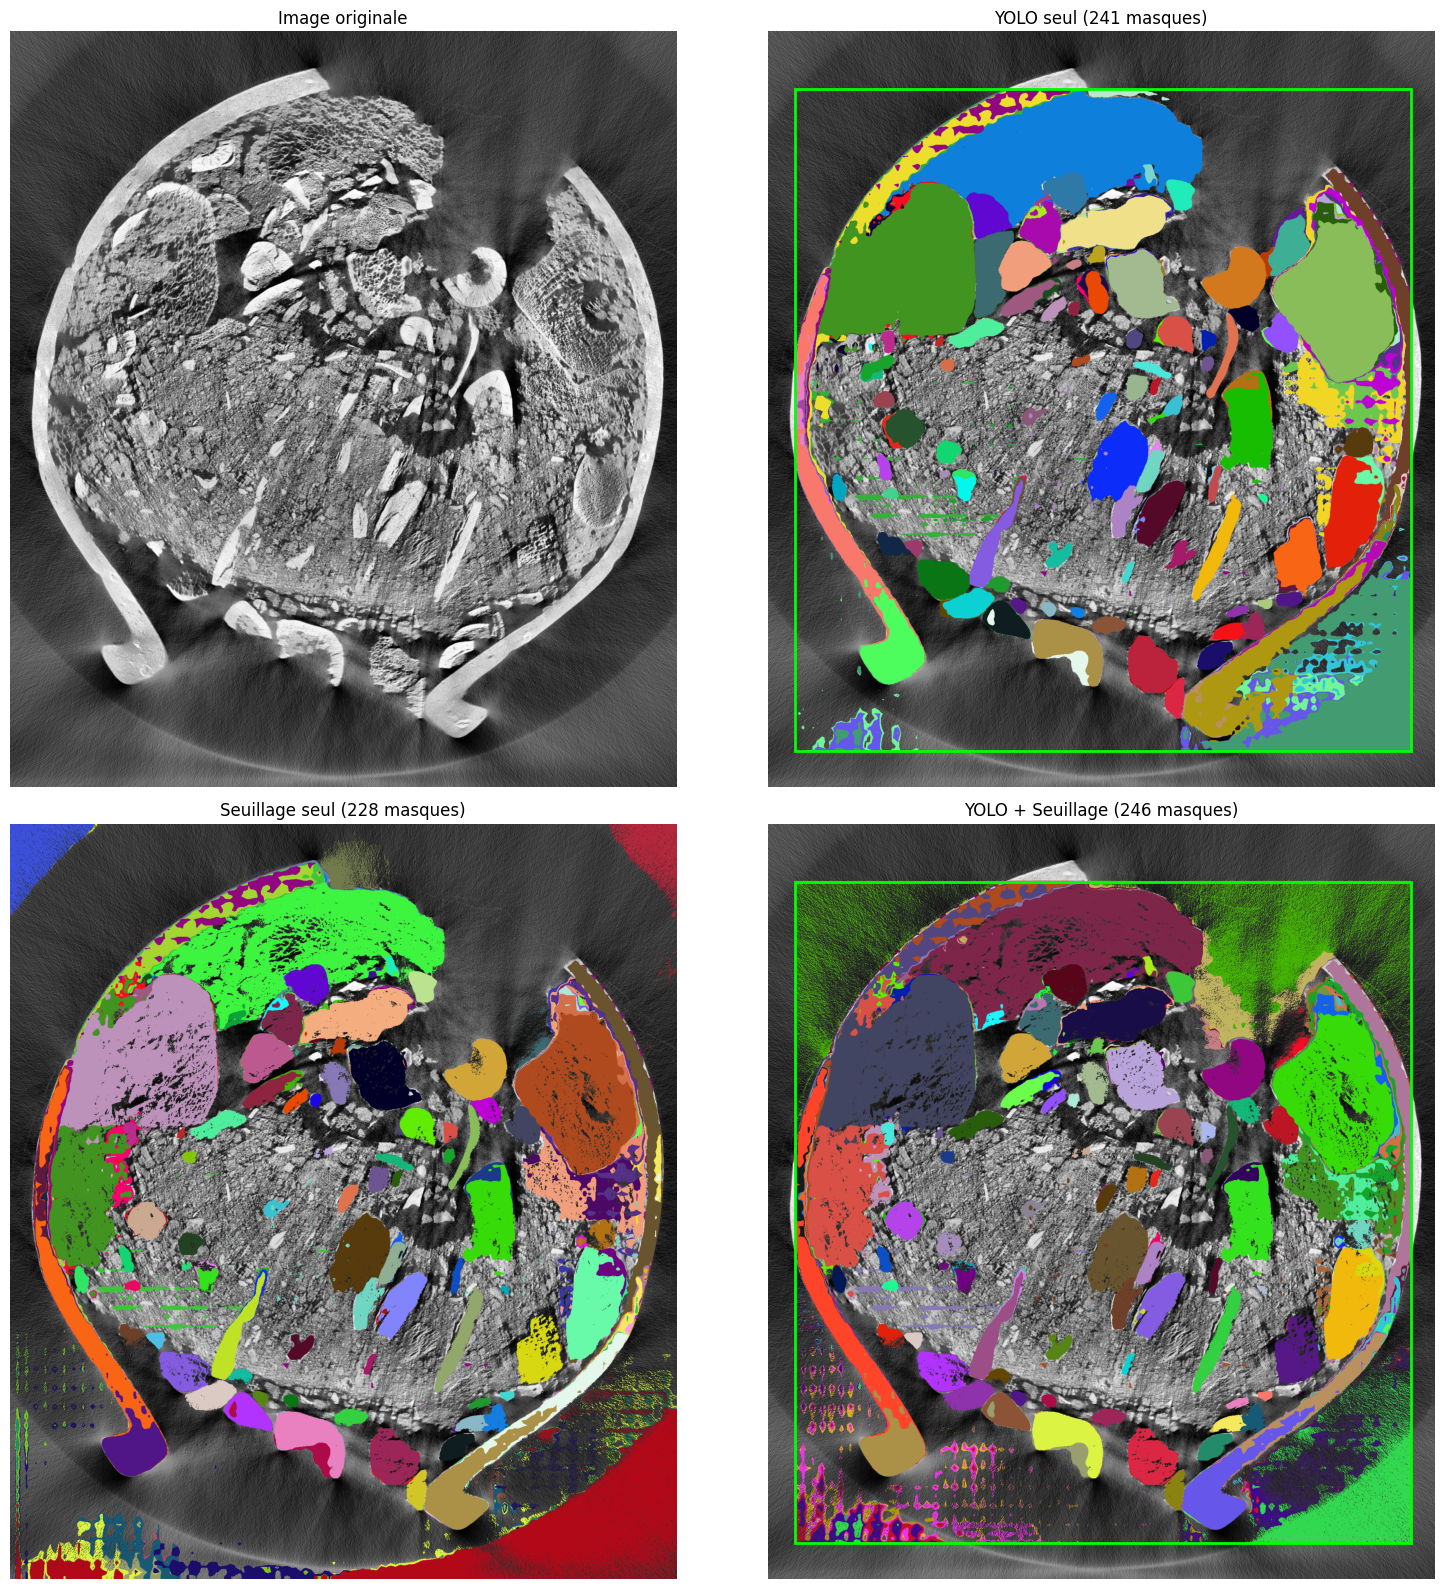

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Image originale
img_original = np.dstack([apply_clahe(vol[mid], use_clahe=True)] * 3).copy()
axes[0, 0].imshow(img_original)
axes[0, 0].set_title("Image originale")
axes[0, 0].axis('off')

# YOLO seul
axes[0, 1].imshow(colored_yolo)
if bbox_yolo is not None:
    x1, y1, x2, y2 = bbox_yolo
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2)
    axes[0, 1].add_patch(rect)
axes[0, 1].set_title(f"YOLO seul ({info_yolo['n_masks_filtered']} masques)")
axes[0, 1].axis('off')

# Seuillage seul
axes[1, 0].imshow(colored_thr)
axes[1, 0].set_title(f"Seuillage seul ({info_thr['n_masks_filtered']} masques)")
axes[1, 0].axis('off')

# YOLO + Seuillage
axes[1, 1].imshow(colored_combined)
if bbox_combined is not None:
    x1, y1, x2, y2 = bbox_combined
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2)
    axes[1, 1].add_patch(rect)
axes[1, 1].set_title(f"YOLO + Seuillage ({info_combined['n_masks_filtered']} masques)")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("ANALYSE IOU AVEC YOLO + SEUILLAGE")
print("="*60)

slice_beginning = mid - 5
slice_end = mid + 5
iou_values_yolo = []

print("\n=== Analyse IoU avec YOLO + seuillage ===\n")

for i in range(slice_beginning, slice_end):
    print(f"Slice {i - slice_beginning + 1}/{slice_end - slice_beginning}")

    # Libérer la mémoire GPU AVANT l'inférence
    if device == "cuda":
        torch.cuda.empty_cache()

    # Slice i
    sl_prev = vol[i]
    sl_prev = apply_clahe(sl_prev, use_clahe=True)
    img_rgb_prev = convert_rgb(sl_prev)

    # Slice i+1
    sl_curr = vol[i + 1]
    sl_curr = apply_clahe(sl_curr, use_clahe=True)
    img_rgb_curr = convert_rgb(sl_curr)

    # Inférence avec YOLO + seuillage
    masks_prev, _, _, _ = sam_inference_with_yolo(
        model,
        model_yolo,
        img_rgb=img_rgb_prev,
        use_yolo=True,
        use_threshold=True,
        threshold_value=60,
        mode="grid",
        grid_stride=GRID_STRIDE,
        device=device,
        conf=CONF_THR,
        min_area=MIN_AREA,
        make_colored=False
    )

    masks_curr, _, _, _ = sam_inference_with_yolo(
        model,
        model_yolo,
        img_rgb=img_rgb_curr,
        use_yolo=True,
        use_threshold=True,
        threshold_value=60,
        mode="grid",
        grid_stride=GRID_STRIDE,
        device=device,
        conf=CONF_THR,
        min_area=MIN_AREA,
        make_colored=False
    )

    # Calculer l'IoU
    iou = match_masks_between_slices(masks_prev, masks_curr)
    iou_values_yolo.append(iou)
    print(f"  IoU: {iou:.4f}")

    # Libérer la mémoire GPU
    if device == "cuda":
        del masks_prev, masks_curr, img_rgb_prev, img_rgb_curr, sl_prev, sl_curr
        torch.cuda.empty_cache()

print("\n=== Résultats YOLO + Seuillage ===")
print(f"IoU values: {iou_values_yolo}")
print(f"Moyenne IoU: {np.mean(iou_values_yolo):.4f}")





ANALYSE IOU AVEC YOLO + SEUILLAGE

=== Analyse IoU avec YOLO + seuillage ===

Slice 1/10
[YOLO] Urne détectée à [1, 3, 1595, 1627]
[Combinaison] YOLO: 2588656 pixels, Seuillage: 2063779 pixels, Combiné: 1838549 pixels

0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 1 132,

In [ ]:
# ============================================================
# CELLULE 6: Comparaison finale (toutes les méthodes)
# ============================================================

print("\n" + "="*60)
print("COMPARAISON FINALE - TOUTES LES MÉTHODES")
print("="*60)

# Supposons que tu as déjà calculé iou_values_grid et iou_values_boxes

mean_iou_grid = np.mean(iou_values_grid) if 'iou_values_grid' in locals() else 0
mean_iou_boxes = np.mean(iou_values_boxes) if 'iou_values_boxes' in locals() else 0
mean_iou_yolo = np.mean(iou_values_yolo)

print(f"Moyenne IoU (grille de points):     {mean_iou_grid:.4f}")
print(f"Moyenne IoU (bounding boxes):       {mean_iou_boxes:.4f}")
print(f"Moyenne IoU (YOLO + seuillage):     {mean_iou_yolo:.4f}")
print("="*60)

# Visualisation comparative
plt.figure(figsize=(12, 6))
x_axis = range(1, len(iou_values_yolo) + 1)

if 'iou_values_grid' in locals():
    plt.plot(x_axis, iou_values_grid, marker='o', label=f"Grille points (moy={mean_iou_grid:.4f})", linewidth=2)
if 'iou_values_boxes' in locals():
    plt.plot(x_axis, iou_values_boxes, marker='s', label=f"Bounding boxes (moy={mean_iou_boxes:.4f})", linewidth=2)
plt.plot(x_axis, iou_values_yolo, marker='^', label=f"YOLO + seuillage (moy={mean_iou_yolo:.4f})", linewidth=2)

plt.xlabel("Index de paire de slices", fontsize=12)
plt.ylabel("IoU", fontsize=12)
plt.title("Comparaison IoU entre slices consécutives\n(Toutes les méthodes)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Exploration 2,5

In [15]:
def create_25d_image(volume, slice_idx, normalize=True):
    D, H, W = volume.shape

    # Gérer les cas limites (bords du volume)
    idx_prev = max(0, slice_idx - 1)
    idx_curr = slice_idx
    idx_next = min(D - 1, slice_idx + 1)

    # Extraire les slices
    slice_prev = volume[idx_prev]
    slice_curr = volume[idx_curr]
    slice_next = volume[idx_next]

    # Normaliser chaque slice indépendamment si demandé
    if normalize:
        slice_prev = normalize_to_uint8(slice_prev)
        slice_curr = normalize_to_uint8(slice_curr)
        slice_next = normalize_to_uint8(slice_next)

    img_25d = np.stack([slice_prev, slice_curr, slice_next], axis=-1)

    return img_25d


def create_25d_image_with_clahe(volume, slice_idx, use_clahe=True):
    """
    Version avec CLAHE appliqué à chaque slice avant empilement
    """
    D, H, W = volume.shape

    # Gérer les cas limites
    idx_prev = max(0, slice_idx - 1)
    idx_curr = slice_idx
    idx_next = min(D - 1, slice_idx + 1)

    # Extraire et prétraiter les slices
    slice_prev = apply_clahe(volume[idx_prev], use_clahe=use_clahe)
    slice_curr = apply_clahe(volume[idx_curr], use_clahe=use_clahe)
    slice_next = apply_clahe(volume[idx_next], use_clahe=use_clahe)

    # Empiler dans les canaux RGB
    img_25d = np.stack([slice_prev, slice_curr, slice_next], axis=-1)

    return img_25d


In [17]:
# Fonction d'inférence SAM 2.5D

def sam_inference_25d(
    model,
    volume,                    # volume 3D [D, H, W]
    slice_idx,                 # index de la slice à segmenter
    urna_mask=None,            # masque booléen [H, W] ou None
    use_clahe=True,            # appliquer CLAHE aux slices
    mode="grid",               # grid, auto ou points
    # paramètres prompts
    grid_stride=64, points=None, labels=None,
    # paramètres SAM
    device="cuda", imgsz=640, iou=0.25, max_det=100, conf=0.75,
    # paramètres filtrage
    min_area=300, max_area_ratio=0.05,
    # colorisation des masques
    make_colored=True, color_seed=0):
    """
    Inférence SAM avec image 2.5D (slices adjacentes comme contexte)
    """

    # Créer l'image 2.5D
    if use_clahe:
        img_25d = create_25d_image_with_clahe(volume, slice_idx, use_clahe=True)
    else:
        img_25d = create_25d_image(volume, slice_idx, normalize=True)

    print(f"[2.5D] Image créée: shape={img_25d.shape}, dtype={img_25d.dtype}")
    print(f"       Slices utilisées: [{max(0, slice_idx-1)}, {slice_idx}, {min(len(volume)-1, slice_idx+1)}]")

    # Utiliser la fonction sam_inference existante
    masks, colored, info = sam_inference(
        model,
        img_rgb=img_25d,
        urna_mask=urna_mask,
        mode=mode,
        grid_stride=grid_stride,
        points=points,
        labels=labels,
        device=device,
        imgsz=imgsz,
        iou=iou,
        max_det=max_det,
        conf=conf,
        min_area=min_area,
        max_area_ratio=max_area_ratio,
        make_colored=make_colored,
        color_seed=color_seed
    )

    # Ajouter des infos sur le mode 2.5D
    info['mode_25d'] = True
    info['slice_idx'] = slice_idx

    return masks, colored, info, img_25d


In [18]:
# ============================================================
# Test segmentation 2D vs 2.5D sur slice du milieu
# ============================================================

print("\n" + "="*60)
print("COMPARAISON SEGMENTATION 2D vs 2.5D")
print("="*60)

# Préparer les masques d'urne
sl_mid = vol[mid]
sl_mid_clahe = apply_clahe(sl_mid, use_clahe=True)
urna_mask = get_urna_mask_threshold(sl_mid, thr=60)

# Test 1: Segmentation 2D classique
print("\n--- Test 1: Segmentation 2D classique ---")
img_rgb_2d = convert_rgb(sl_mid_clahe)
masks_2d, colored_2d, info_2d = sam_inference(
    model,
    img_rgb=img_rgb_2d,
    urna_mask=urna_mask,
    mode="grid",
    grid_stride=GRID_STRIDE,
    device=device,
    conf=CONF_THR,
    min_area=MIN_AREA,
    max_area_ratio=0.05,
    make_colored=True
)
print(f"Résultat 2D: {info_2d}")

# Test 2: Segmentation 2.5D
print("\n--- Test 2: Segmentation 2.5D ---")
masks_25d, colored_25d, info_25d, img_25d = sam_inference_25d(
    model,
    volume=vol,
    slice_idx=mid,
    urna_mask=urna_mask,
    use_clahe=True,
    mode="grid",
    grid_stride=GRID_STRIDE,
    device=device,
    conf=CONF_THR,
    min_area=MIN_AREA,
    max_area_ratio=0.05,
    make_colored=True
)
print(f"Résultat 2.5D: {info_25d}")

# Libérer mémoire
if device == "cuda":
    torch.cuda.empty_cache()




COMPARAISON SEGMENTATION 2D vs 2.5D

--- Test 1: Segmentation 2D classique ---

0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 39, 1 42, 1 44, 1 45, 1 47, 1 48, 1 49, 1 50, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 70, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 88, 1 89, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 124, 1 125, 1 126, 1 128, 1 129, 1 132, 1 133, 1 134, 1 135, 1 136, 1 137, 1 138, 1 139, 1 141, 1 142, 1 143, 1 144, 1 145, 1 146, 1 147, 1 148, 1 149, 1 150, 1 153, 1 154, 1 156, 1 157, 1 158, 1 159, 1 161, 1 164, 1 166, 1 169, 1 170, 1 171, 1 17

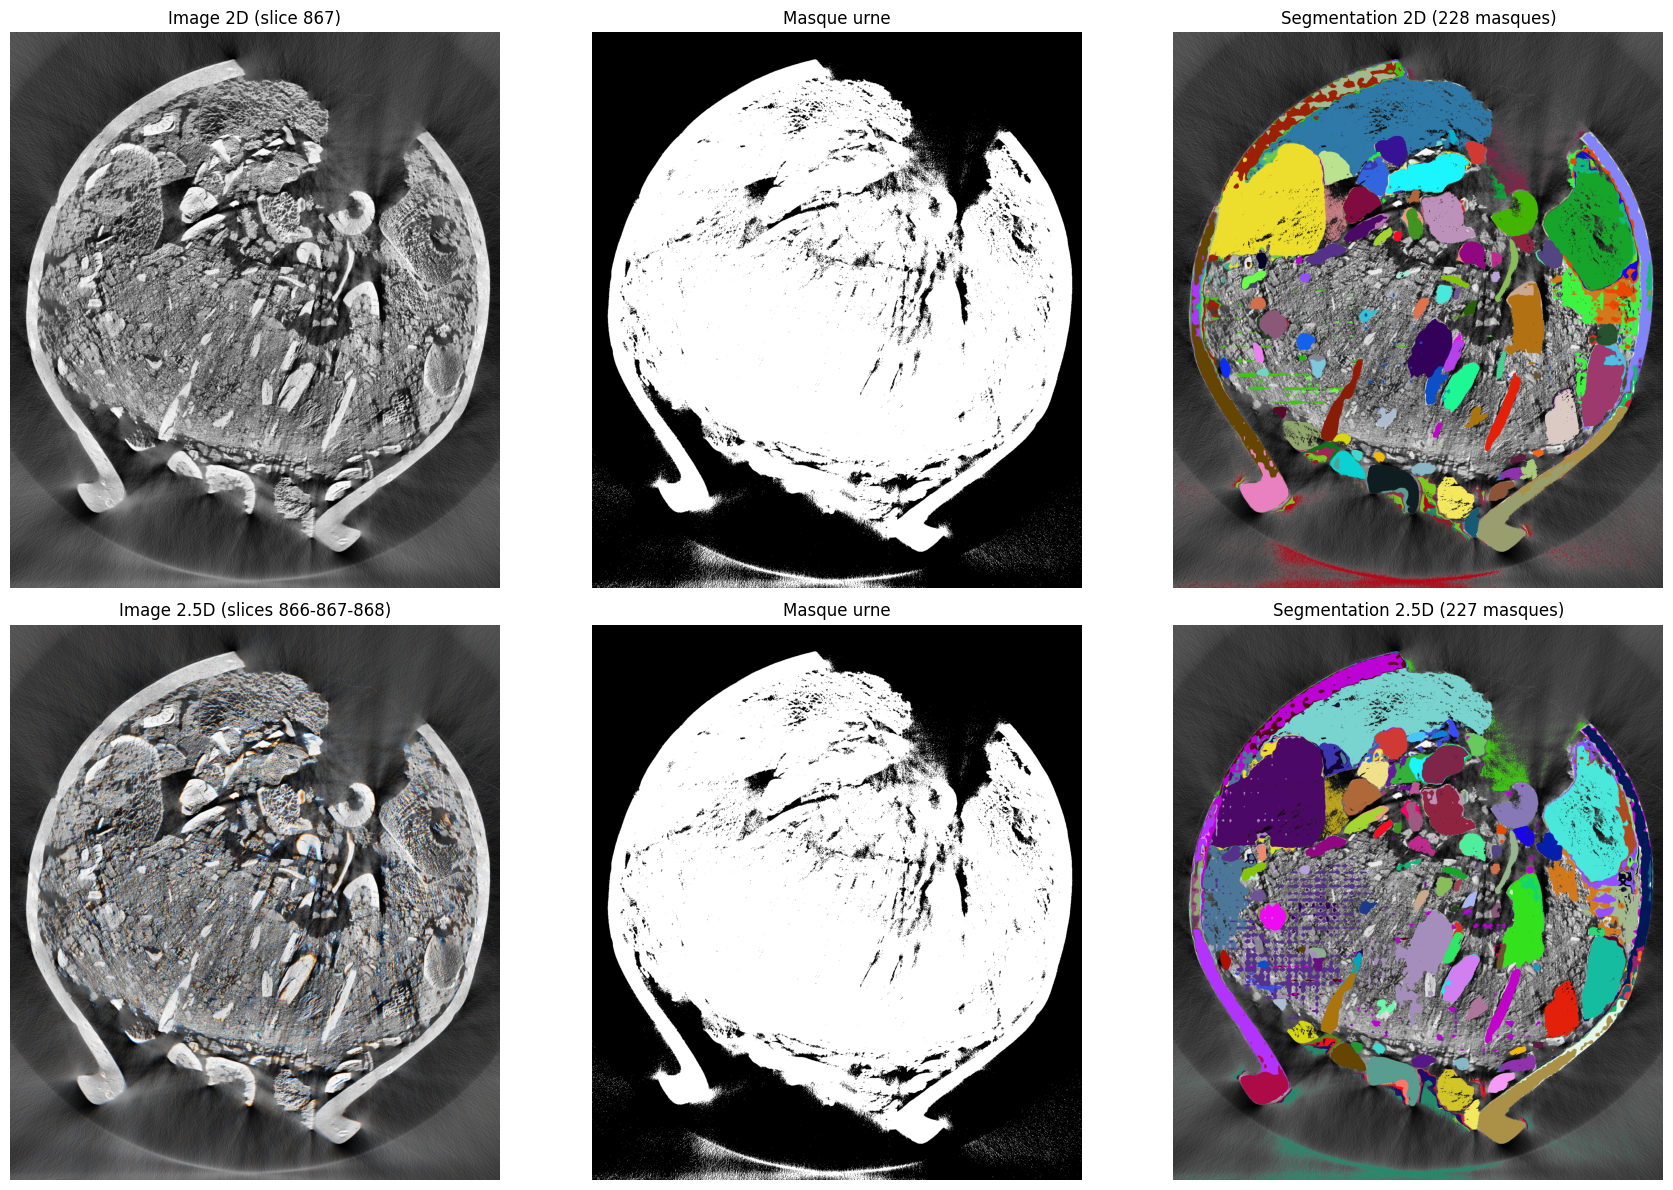


STATISTIQUES COMPARATIVES
2D  : 228 masques détectés
2.5D: 227 masques détectés
Différence: -1 masques


In [19]:
# ============================================================
# Visualisation 2D vs 2.5D
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ligne 1: 2D classique
axes[0, 0].imshow(img_rgb_2d)
axes[0, 0].set_title(f"Image 2D (slice {mid})")
axes[0, 0].axis('off')

axes[0, 1].imshow(urna_mask, cmap='gray')
axes[0, 1].set_title("Masque urne")
axes[0, 1].axis('off')

axes[0, 2].imshow(colored_2d)
axes[0, 2].set_title(f"Segmentation 2D ({info_2d['n_masks_filtered']} masques)")
axes[0, 2].axis('off')

# Ligne 2: 2.5D
axes[1, 0].imshow(img_25d)
axes[1, 0].set_title(f"Image 2.5D (slices {max(0,mid-1)}-{mid}-{min(len(vol)-1,mid+1)})")
axes[1, 0].axis('off')

axes[1, 1].imshow(urna_mask, cmap='gray')
axes[1, 1].set_title("Masque urne")
axes[1, 1].axis('off')

axes[1, 2].imshow(colored_25d)
axes[1, 2].set_title(f"Segmentation 2.5D ({info_25d['n_masks_filtered']} masques)")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Statistiques comparatives
print("\n" + "="*60)
print("STATISTIQUES COMPARATIVES")
print("="*60)
print(f"2D  : {info_2d['n_masks_filtered']} masques détectés")
print(f"2.5D: {info_25d['n_masks_filtered']} masques détectés")
print(f"Différence: {info_25d['n_masks_filtered'] - info_2d['n_masks_filtered']} masques")
print("="*60)

In [ ]:
print("\n" + "="*60)
print("ANALYSE IOU AVEC SEGMENTATION 2.5D")
print("="*60)

slice_start = mid
num_slices = 10
iou_values_25d = []

print("\n=== Analyse IoU avec approche 2.5D (slice fixe) ===\n")

# 1. Nettoyer AVANT de commencer
torch.cuda.empty_cache()

# Préparer la slice de référence
sl_ref_2d = apply_clahe(vol[slice_start], use_clahe=True)
urna_mask_ref = get_urna_mask_threshold(sl_ref_2d, thr=60)

# Inférence SAM 2.5D sur la slice de référence
with torch.no_grad():  
    masks_ref, _, _, _ = sam_inference_25d(
        model,
        volume=vol,
        slice_idx=slice_start,
        urna_mask=urna_mask_ref,
        use_clahe=True,
        mode="grid",
        grid_stride=GRID_STRIDE,
        device=device,
        conf=CONF_THR,
        min_area=MIN_AREA,
        max_area_ratio=0.05,
        make_colored=False
    )
    
    if isinstance(masks_ref, torch.Tensor):
        masks_ref = masks_ref.cpu().numpy()

# Nettoyer après la référence
torch.cuda.empty_cache()

for i in range(slice_start + 1, slice_start + 1 + num_slices):
    print(f"Comparaison slice {slice_start} vs slice {i}")
    
    # Nettoyer AVANT chaque itération
    torch.cuda.empty_cache()
    
    # Préparer le masque de la slice courante
    sl_curr_2d = apply_clahe(vol[i], use_clahe=True)
    urna_mask_curr = get_urna_mask_threshold(sl_curr_2d, thr=60)
    
    with torch.no_grad():  
        masks_curr, _, _, _ = sam_inference_25d(
            model,
            volume=vol,
            slice_idx=i,
            urna_mask=urna_mask_curr,
            use_clahe=True,
            mode="grid",
            grid_stride=GRID_STRIDE,
            device=device,
            conf=CONF_THR,
            min_area=MIN_AREA,
            max_area_ratio=0.05,
            make_colored=False
        )
        
        if isinstance(masks_curr, torch.Tensor):
            masks_curr = masks_curr.cpu().numpy()
    
    # Calculer l'IoU (maintenant avec numpy arrays)
    iou = match_masks_between_slices(masks_ref, masks_curr)
    iou_values_25d.append(iou)
    print(f"  IoU: {iou:.4f}")
    
    # Libérer explicitement
    del masks_curr, sl_curr_2d, urna_mask_curr
    torch.cuda.empty_cache()

print("\n=== Résultats 2.5D ===")
print(f"IoU values: {iou_values_25d}")
print(f"Moyenne IoU: {np.mean(iou_values_25d):.4f}")

# Nettoyage final
del masks_ref, sl_ref_2d, urna_mask_ref
torch.cuda.empty_cache()

"""print("\n" + "="*60)
print("ANALYSE IOU AVEC SEGMENTATION 2.5D")
print("="*60)

slice_start = mid  # slice de référence
num_slices = 10   # nombre de slices à comparer
iou_values_25d = []

print("\n=== Analyse IoU avec approche 2.5D (slice fixe) ===\n")

# Préparer la slice de référence
sl_ref_2d = apply_clahe(vol[slice_start], use_clahe=True)
urna_mask_ref = get_urna_mask_threshold(sl_ref_2d, thr=60)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Inférence SAM 2.5D sur la slice de référence
masks_ref, _, _, _ = sam_inference_25d(
    model,
    volume=vol,
    slice_idx=slice_start,
    urna_mask=urna_mask_ref,
    use_clahe=True,
    mode="grid",
    grid_stride=GRID_STRIDE,
    device=device,
    conf=CONF_THR,
    min_area=MIN_AREA,
    max_area_ratio=0.05,
    make_colored=False
)

for i in range(slice_start + 1, slice_start + 1 + num_slices):
    print(f"Comparaison slice {slice_start} vs slice {i}")

    if device == "cuda":
        torch.cuda.empty_cache()

    # Préparer le masque de la slice courante
    sl_curr_2d = apply_clahe(vol[i], use_clahe=True)
    urna_mask_curr = get_urna_mask_threshold(sl_curr_2d, thr=60)

    masks_curr, _, _, _ = sam_inference_25d(
        model,
        volume=vol,
        slice_idx=i,
        urna_mask=urna_mask_curr,
        use_clahe=True,
        mode="grid",
        grid_stride=GRID_STRIDE,
        device=device,
        conf=CONF_THR,
        min_area=MIN_AREA,
        max_area_ratio=0.05,
        make_colored=False
    )

    # Calculer l'IoU avec la slice de référence
    iou = match_masks_between_slices(masks_ref, masks_curr)
    iou_values_25d.append(iou)
    print(f"  IoU: {iou:.4f}")

    # Libérer la mémoire GPU
    del masks_curr
    torch.cuda.empty_cache()

print("\n=== Résultats 2.5D ===")
print(f"IoU values: {iou_values_25d}")
print(f"Moyenne IoU: {np.mean(iou_values_25d):.4f}")

# Libérer la mémoire du masque de référence à la fin
del masks_ref
torch.cuda.empty_cache()
"""


ANALYSE IOU AVEC SEGMENTATION 2.5D

=== Analyse IoU avec approche 2.5D (slice fixe) ===

[2.5D] Image créée: shape=(1808, 1595, 3), dtype=uint8
       Slices utilisées: [866, 867, 868]

0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 76, 1 77, 1 78, 1 79, 1 81, 1 82, 1 83, 1 84, 1 86, 1 87, 1 89, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 133, 1 134, 1 135, 1 136, 1 137, 1 139, 1 140, 1 141, 1 142, 

'print("\n" + "="*60)\nprint("ANALYSE IOU AVEC SEGMENTATION 2.5D")\nprint("="*60)\n\nslice_start = mid  # slice de référence\nnum_slices = 10   # nombre de slices à comparer\niou_values_25d = []\n\nprint("\n=== Analyse IoU avec approche 2.5D (slice fixe) ===\n")\n\n# Préparer la slice de référence\nsl_ref_2d = apply_clahe(vol[slice_start], use_clahe=True)\nurna_mask_ref = get_urna_mask_threshold(sl_ref_2d, thr=60)\n\ntorch.cuda.empty_cache()\ntorch.cuda.reset_peak_memory_stats()\n\n# Inférence SAM 2.5D sur la slice de référence\nmasks_ref, _, _, _ = sam_inference_25d(\n    model,\n    volume=vol,\n    slice_idx=slice_start,\n    urna_mask=urna_mask_ref,\n    use_clahe=True,\n    mode="grid",\n    grid_stride=GRID_STRIDE,\n    device=device,\n    conf=CONF_THR,\n    min_area=MIN_AREA,\n    max_area_ratio=0.05,\n    make_colored=False\n)\n\nfor i in range(slice_start + 1, slice_start + 1 + num_slices):\n    print(f"Comparaison slice {slice_start} vs slice {i}")\n\n    if device == "cuda"


COMPARAISON FINALE - 2D vs 2.5D
Moyenne IoU (2D classique):          0.0000
Moyenne IoU (2.5D - slices adj.):    0.6385
Amélioration:                         +0.6385


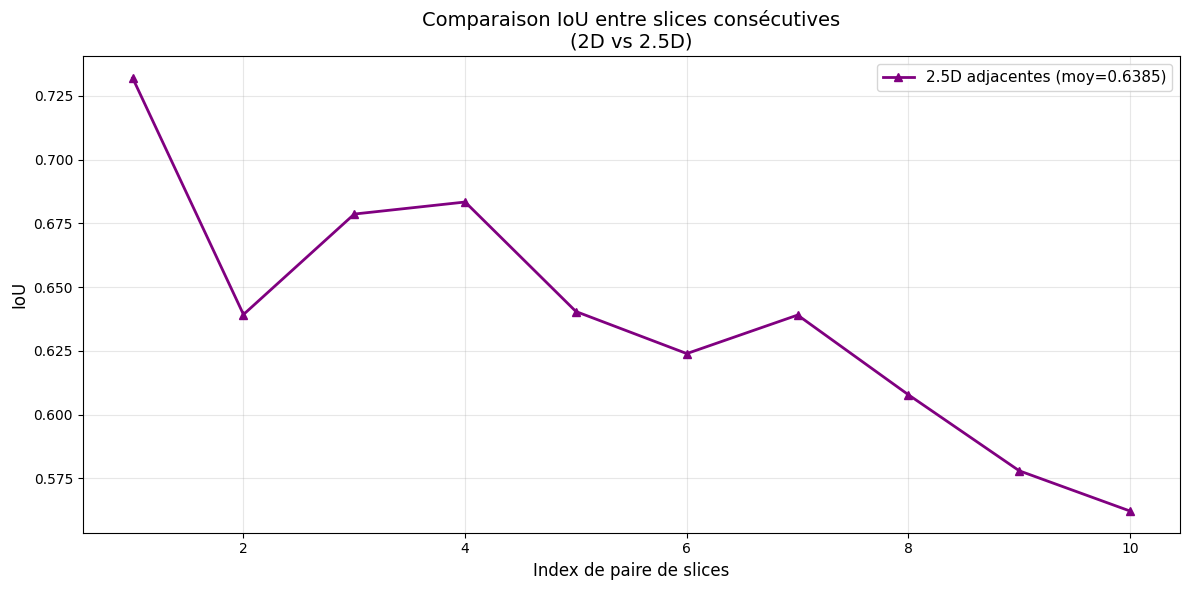

In [26]:
# Comparaison finale 2D vs 2.5D


print("\n" + "="*60)
print("COMPARAISON FINALE - 2D vs 2.5D")
print("="*60)


mean_iou_2d = np.mean(iou_values_grid) if 'iou_values_grid' in locals() else 0
mean_iou_25d = np.mean(iou_values_25d)

print(f"Moyenne IoU (2D classique):          {mean_iou_2d:.4f}")
print(f"Moyenne IoU (2.5D - slices adj.):    {mean_iou_25d:.4f}")
print(f"Amélioration:                         {mean_iou_25d - mean_iou_2d:+.4f}")
print("="*60)


plt.figure(figsize=(12, 6))
x_axis = range(1, len(iou_values_25d) + 1)

if 'iou_values_grid' in locals():
    plt.plot(x_axis, iou_values_grid, marker='o', label=f"2D classique (moy={mean_iou_2d:.4f})", linewidth=2)
plt.plot(x_axis, iou_values_25d, marker='^', label=f"2.5D adjacentes (moy={mean_iou_25d:.4f})", linewidth=2, color='purple')

plt.xlabel("Index de paire de slices", fontsize=12)
plt.ylabel("IoU", fontsize=12)
plt.title("Comparaison IoU entre slices consécutives\n(2D vs 2.5D)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


VISUALISATION DES CANAUX 2.5D


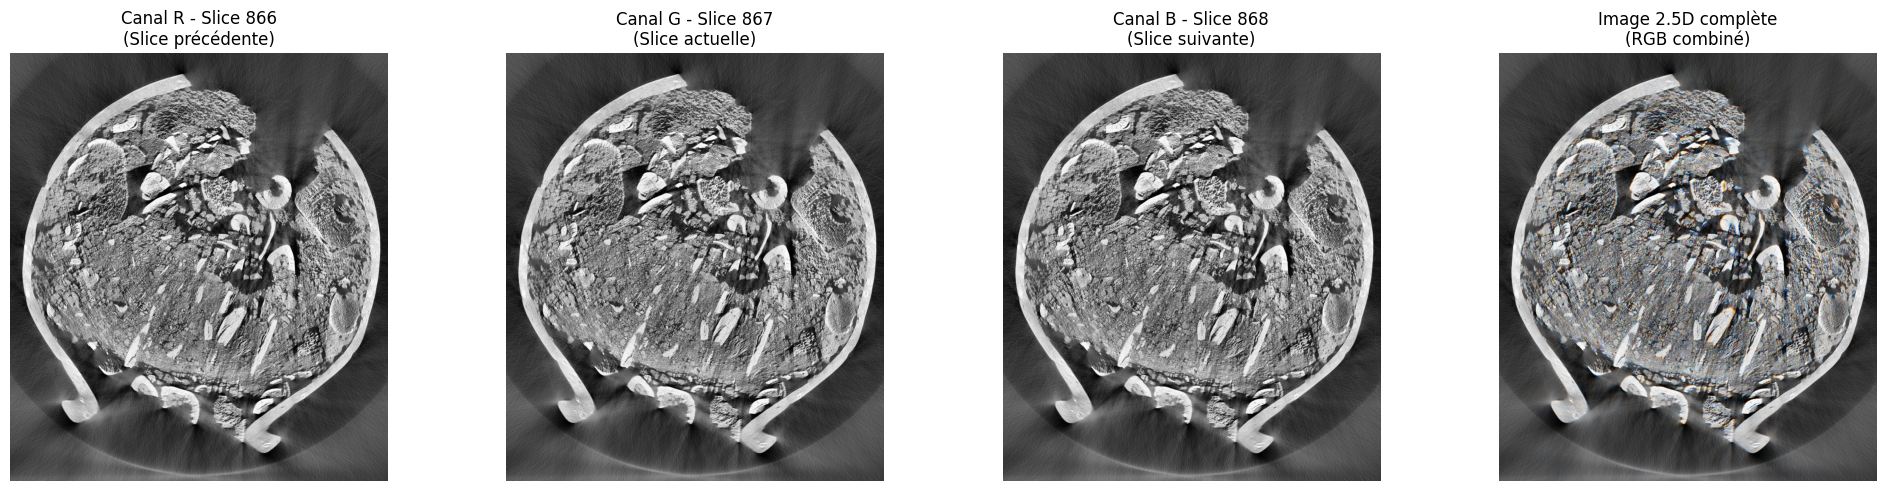

In [24]:
# Visualisation détaillée des canaux 2.5D

print("\n" + "="*60)
print("VISUALISATION DES CANAUX 2.5D")
print("="*60)

img_25d_vis = create_25d_image_with_clahe(vol, mid, use_clahe=True)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(img_25d_vis[:, :, 0], cmap='gray')
axes[0].set_title(f"Canal R - Slice {max(0, mid-1)}\n(Slice précédente)")
axes[0].axis('off')

axes[1].imshow(img_25d_vis[:, :, 1], cmap='gray')
axes[1].set_title(f"Canal G - Slice {mid}\n(Slice actuelle)")
axes[1].axis('off')

axes[2].imshow(img_25d_vis[:, :, 2], cmap='gray')
axes[2].set_title(f"Canal B - Slice {min(len(vol)-1, mid+1)}\n(Slice suivante)")
axes[2].axis('off')


axes[3].imshow(img_25d_vis)
axes[3].set_title("Image 2.5D complète\n(RGB combiné)")
axes[3].axis('off')

plt.tight_layout()
plt.show()



## Exploration des différents axes

### Save codecarbon results and stop tracking

In [ ]:
emissions = tracker.stop()
print("Emissions (kg CO2eq) :", emissions)

In [ ]:
with open("emissions.csv", "a", newline="") as f:
    writer = csv.writer(f)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    writer.writerow([timestamp, emissions])
